## 1 - Introduction
In this notebook, we're going to explore a data set consisting of simulated data from the ATLAS-experiment which is located at the Large Hadron Collider at CERN. We'll look at the distribution of the data and labels, and explore the many existing techniques for data augmentation in deep learning for computer vision. Then we'll train a model to see how well it can classify between the two labels: black holes and sphalerons - which are two theories in fundamental phyics with similar propeties. The data set was generated by Aurora Grefsrud, a PhD-student who is a part of a research group called HVL ATLAS group at the Western Norway University of Applied Sciences. 

## 2 - Setup
We're using the PyTorch setup which is great at building and training deep neural networks, such as convolutional neural networks (CNNs). 

In [1]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt

import sys
from pathlib import Path

import torch
from torch.utils.data import DataLoader
import torch.nn as nn
from torch import Tensor
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

from torch import Tensor
from torch.utils import data

from sklearn.model_selection import train_test_split

### 2.1 - Sets up the data directories
This section covers the setup of the environment for our machine learning project. We import the necessary modules, set up the directory structure, and load the data for our analysis.

In the methods folder there is a dataloader.py file and a plotCreator.py file. The separate dataloader-file provides an interface to load and preprocess data into a format that can be fed into a neural network for training and validation. 

The separate plotCreator-file provides a modile that contains functions for creating visualizations of data, such as histograms and grayscale images. These can be useful in analyzing and understanding the data used in a neural network.

Keeping them separate files improves the modularity, organization, and maintainability of the code. 

In [2]:
# Constructs a path to a directory that contains dataloader.py and plotCreator.py
module_path = str(Path.cwd().parents[0] / "methods")

# Checks to see if the directory is already in sys.path to avoid adding it multiple times.
if module_path not in sys.path:
    sys.path.append(module_path)

# Imports all the functions defined in the dataloader.py
from dataloader import *

# Creates two file paths pointing to two HDF5 files
data_path0 = str(Path.cwd().parents[0] / "data" / "BH_n4_M10_res50_15000_events.h5")
data_path1 = str(Path.cwd().parents[0] / "data" / "PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL_res50_15000_events.h5")

In [3]:
# Reads the two HDF5 data files and creates two NumPy arrays
bhArray = dataToArray(data_path0)
sphArray = dataToArray(data_path1)

## 3 - Inspect data
What are the dimensions of our two numpy arrays, and how does this effect what we know about the dataset?

In [4]:
# Prints the shape of the arrays
print(bhArray.shape)
print(sphArray.shape)

(15000, 50, 50, 3)
(15000, 50, 50, 3)


The tuple represents the simulated data from the ATLAS detector at CERN, consisting of 15,000 2D histograms. The second and third elements of the tuple indicate that each histogram has a size of 50x50 pixels, and the final element indicates that the histograms are in RGB format with 3 channels. The channels correspond to the sub-detectors at ATLAS: EMcal, HCal, and tracks, represented respectively by the red, green, and blue color channels.

## 4 - Data preparation

In [5]:
# Combines the two arrays of data into a single array. It creates a combined dataset
# that can be used for training the machine learning model to distinguish 
# between the two classes.
dataArray = np.concatenate((bhArray, sphArray), axis=0)

In [6]:
np.shape(dataArray)

(30000, 50, 50, 3)

The output of the dataArray tells us that the concatenation of the 'bhArray' and 'sphArray' was performed correctly, since it has the expected number of data points and dimensions.

In [7]:
# Creating an array of length 30,000 with the first 15,000 elements set to 0 and the
# second 15,000 elements set to 1. This corresponds to the two classes of data: black
# hole (class 0) and sphaleron (class 1).
labelsArray = np.concatenate((np.zeros(15_000),np.ones(15_000)),axis=0)

In [8]:
np.shape(labelsArray)

(30000,)

The output from the above cell tells us that we have managed to separate our arrays into two different arrays. The dataArray contains the features, which is the actual data, while the labelsArray only contains the labels. This makes it possible for the machine learning algorithm to utilize supervised machine learning.

In [9]:
# Checks whether a CUDA-enabled GPU is available on the system where the code is running.
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

Running on the GPU


### 4.1 - Create training and test sets


In [10]:
# Randomly splits the dataArray and labelsArray into two sets. The trainData and trainLabels
# will be used to train the machine learning model, while the testData and testLabels will be 
# used to evaluate the performance of the model. 
trainData, testData, trainLabels, testLabels = train_test_split(dataArray, labelsArray, random_state=42)

### 4.2 - Data loaders

In [11]:
# Converts the NumPy arrays into PyTorch tensors, preparing the data for use in PyTorch models.
trainData = torch.from_numpy(trainData)
testData = torch.from_numpy(testData)
trainLabels = torch.from_numpy(trainLabels)
testLabels = torch.from_numpy(testLabels)

In [12]:
# Creates PyTorch 'TensorDataset' objects that can be passed as input to PyTorch data loaders.
train = torch.utils.data.TensorDataset(trainData, trainLabels)
test = torch.utils.data.TensorDataset(testData, testLabels)

In [13]:
# Creates PyTorch 'DataLoader' objects from the train and test datasets.
trainLoader = DataLoader(train, shuffle=True, batch_size=50)
testLoader = DataLoader(test, shuffle=True, batch_size=50)

'shuffle = True' specifies that the data should be randomly shuffled before each epoch of training. This helps to ensure that the models sees different examples in each epoch, which can improve generalization and prevent overfitting.

'batch_size = 50' specifiees that the data should be divided into batches of size 50. Batchin the data can help to improve the efficiency of training by allowing the model to process multiple examples in parallel.

## 5 - Neural network models

### 5.1 - A feedforward neural network
Defines a simple feedforward neural network with three fully connected layers and ReLU activation functions. It is designed for classification tasks on input data with three features.

### 5.2 - A convolutional neural network (CNN)
Defines a convolutional neural network (CNN) with two convolutional layers, two max-pooling layers, and two fully connected layers, and is designed for classification tasks on 2D image data with 3 channels (RGB images). These types of neural networks are commonly used for image classification tasks because it is effective at learning spatial features and patterns from the image data. 

In [14]:
#Define the ConvModel class
class ConvModel(nn.Module):
    #Constructor that initializes the layers of the model
    def __init__(self, dropout):

        super(ConvModel, self).__init__()
        #opprette conv lag. Bildene har 3 lag 
        #Define convolutional layers for the input image
        #Input image has 3 challes, 3 layers
        #The first convolutional layer has 16 output channels and uses a kernel size of 3x3
        #ANd padding is set to 0
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=0)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=64, kernel_size=3, padding=0)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=256, kernel_size=3, padding=0)
        #kanskje ha flere layers?

        #Unchange
        #Define fully connected layers
        #Input size to the first fully connected layer is 3*3*256
        #The first fully connected layer has 128 output units
        #The secon fully connected layer has 2 output units
        self.fc1 = nn.Linear(3*3*256, 128)
        self.fc2 = nn.Linear(128,2)

        #Define the dropout layer to prevent overfitting
        self.dropout = nn.Dropout(dropout)


    #Enten her eller over skal komme endringane for convolutional layer
    def forward(self, x:Tensor):
        
        #x = F.conv2d(x, self.conv1_filter, bias=self.conv1.bias, stride=1, padding=1)
        #Apply first conv layer
        x= self.conv1(x)
        #Apply relu activation function
        x = F.relu(x) 
        #Apply max pooling with a kernel size 2
        x = F.max_pool2d(x,2)
        #Apply the second conv layer
        x = self.conv2(x)
        #Apply relu activation function
        x = F.relu(x)
        #Apply max pooling with a kernel size of 2
        x = F.max_pool2d(x,2)
        #Apply the third conv layer
        x = self.conv3(x)
        #Apply relu activation function
        x = F.relu(x)
        #Appply max pooling with a kernel size 3
        x = F.max_pool2d(x,3)
        
        #Flatten the output of the conv layers
        x = torch.flatten(x, 1)
        
        #Apply the first fully connected layer
        x = self.fc1(x)
        #Apply relu activation function
        x = F.relu(x)
        x = self.dropout(x)
        #Apply teh second fully connected layer
        x = self.fc2(x)
        x = self.dropout(x)
        #Apply droput to layers??
        return x

In [15]:
from torchsummary import summary

#Her måp det endres sidan den aksepterer ikek parametere gitt
model = ConvModel(0).to(device)
summary(model, (3, 50, 50))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 48, 48]             448
            Conv2d-2           [-1, 64, 22, 22]           9,280
            Conv2d-3            [-1, 256, 9, 9]         147,712
            Linear-4                  [-1, 128]         295,040
           Dropout-5                  [-1, 128]               0
            Linear-6                    [-1, 2]             258
           Dropout-7                    [-1, 2]               0
Total params: 452,738
Trainable params: 452,738
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.03
Forward/backward pass size (MB): 0.68
Params size (MB): 1.73
Estimated Total Size (MB): 2.43
----------------------------------------------------------------


In [16]:
def train(model, train_loader, test_loader, optimizer, criterion, n_epochs):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)

    #Create empty tabel that will be used to plot accuracy throughout epoch runs
    arr = []
        
    for epoch in range(n_epochs):
        # Train
        model.train()
        train_loss = 0
        
        correct = 0
        total = 0
        
        #Train loop
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device).float(), labels.to(device).long()
            optimizer.zero_grad()
            outputs = model(inputs.permute(0, 3, 1, 2)).float()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
        #Train loop end
        
        
        train_acc = 100 * correct / total
        train_loss /= len(train_loader)
        

        # Test
        model.eval()
        test_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device).float(), labels.to(device).long()
                outputs = model(inputs.permute(0, 3, 1, 2)).float()
                loss = criterion(outputs, labels)

                test_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        test_acc = 100 * correct / total
        test_loss /= len(test_loader)

        # Print results
        
        print(f"Epoch {epoch+1}/{n_epochs}")
        print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%")
        print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")
        
        arr.append(train_acc)
    
    return arr    
        #PRInt grafisk din løk

Epoch 1/20
Train Loss: 0.7898, Train Accuracy: 66.75%
Test Loss: 0.4384, Test Accuracy: 81.63%
Epoch 2/20
Train Loss: 0.4929, Train Accuracy: 74.01%
Test Loss: 0.3661, Test Accuracy: 84.55%
Epoch 3/20
Train Loss: 0.4480, Train Accuracy: 76.71%
Test Loss: 0.3320, Test Accuracy: 86.28%
Epoch 4/20
Train Loss: 0.4398, Train Accuracy: 76.66%
Test Loss: 0.3516, Test Accuracy: 86.59%
Epoch 5/20
Train Loss: 0.4232, Train Accuracy: 77.51%
Test Loss: 0.2939, Test Accuracy: 87.88%
Epoch 6/20
Train Loss: 0.4129, Train Accuracy: 77.60%
Test Loss: 0.3011, Test Accuracy: 88.07%
Epoch 7/20
Train Loss: 0.4042, Train Accuracy: 78.16%
Test Loss: 0.3041, Test Accuracy: 87.20%
Epoch 8/20
Train Loss: 0.3912, Train Accuracy: 79.19%
Test Loss: 0.3186, Test Accuracy: 85.61%
Epoch 9/20
Train Loss: 0.3982, Train Accuracy: 78.28%
Test Loss: 0.2819, Test Accuracy: 88.43%
Epoch 10/20
Train Loss: 0.3851, Train Accuracy: 79.08%
Test Loss: 0.2766, Test Accuracy: 88.13%
Epoch 11/20
Train Loss: 0.3737, Train Accuracy: 7

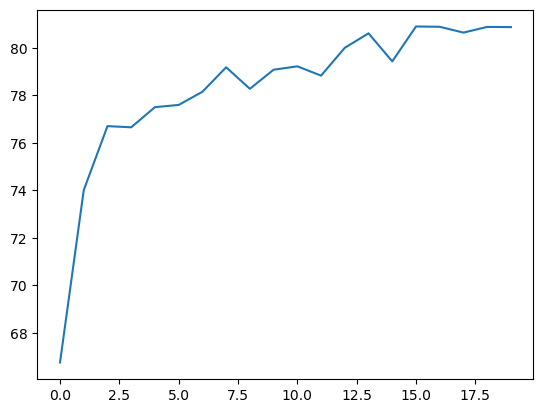

In [17]:
model = ConvModel(dropout=0.5)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

tabell = train(model, trainLoader, testLoader, optimizer, criterion, n_epochs=20)

plt.plot(range(len(tabell)), tabell)